In [ ]:
import eval_utils.rollout_doc_file_processor as rollout_doc_file_processor
import eval_utils.plotter as plotter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [2]:
dir_path = "log/hopper-medium-v2/mobile&penalty_coef=1.5&rollout_length=5&real_ratio=0.05/seed_1_timestamp_25-0906-124444_benchmark/rollout_docs"
env_name = "Hopper-v2"
target_acceptance_ratio = 0.98

In [3]:
doc_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.json')]

In [4]:
docs = rollout_doc_file_processor.load_rollout_docs(doc_paths, add_model_error_if_not_contained=True, env=env_name, cast_to_nparray=False, verbose=True)

Processing rollout document log/hopper-medium-v2/mobile&penalty_coef=1.5&rollout_length=5&real_ratio=0.05/seed_1_timestamp_25-0906-124444_benchmark/rollout_docs/epoch_200_timesteps_199000_rollout_doc.json
Rollout document log/hopper-medium-v2/mobile&penalty_coef=1.5&rollout_length=5&real_ratio=0.05/seed_1_timestamp_25-0906-124444_benchmark/rollout_docs/epoch_200_timesteps_199000_rollout_doc.json already contains next_obss_real and model_error_l2
Processing rollout document log/hopper-medium-v2/mobile&penalty_coef=1.5&rollout_length=5&real_ratio=0.05/seed_1_timestamp_25-0906-124444_benchmark/rollout_docs/epoch_250_timesteps_249000_rollout_doc.json
Rollout document log/hopper-medium-v2/mobile&penalty_coef=1.5&rollout_length=5&real_ratio=0.05/seed_1_timestamp_25-0906-124444_benchmark/rollout_docs/epoch_250_timesteps_249000_rollout_doc.json already contains next_obss_real and model_error_l2
Processing rollout document log/hopper-medium-v2/mobile&penalty_coef=1.5&rollout_length=5&real_ratio

In [5]:
# add epoch info to docs
for doc, path in zip(docs, doc_paths):
    match = re.search(r'epoch_(\d+)', path)
    if match:
        epoch = int(match.group(1))
        n = len(doc['obss'])
        doc["epoch"] = [epoch] * n

In [6]:
# consolidate all dicts in docs
consolidated_doc = {}
for doc in docs:
    for key, value in doc.items():
        if key not in consolidated_doc:
            consolidated_doc[key] = []
        consolidated_doc[key] += value
docs = None

In [7]:
consolidated_doc.keys()

dict_keys(['obss', 'next_obss_predicted', 'actions', 'step_nr', 'aleatoric', 'dimensionwise_diff_with_std', 'pairwise-diff', 'pairwise-diff_with_std', 'ensemble_std', 'dimensionwise_ood_measure', 'next_obss_real', 'rewards_real', 'model_error_l2', 'epoch'])

In [8]:
for k,v in consolidated_doc.items():
    consolidated_doc[k] = np.array(v)

In [9]:
    # doc = rollout_doc_file_processor.load_rollout_docs("log/hopper-medium-expert-v2/combo/seed_1_timestamp_25-0825-124532/rollout_docs/epoch_220_timesteps_219000_rollout_doc.json")
    # doc = doc[0]
    # doc.keys()

doc = consolidated_doc

In [10]:
uncertainty_measures = list(doc.keys())
uncertainty_measures.remove('obss')
uncertainty_measures.remove('actions')
uncertainty_measures.remove('next_obss_predicted')
uncertainty_measures.remove('next_obss_real')
uncertainty_measures.remove('model_error_l2')
uncertainty_measures.remove('rewards_real')
uncertainty_measures.remove('epoch')
uncertainty_measures.remove('step_nr')

uncertainty_measures

['aleatoric',
 'dimensionwise_diff_with_std',
 'pairwise-diff',
 'pairwise-diff_with_std',
 'ensemble_std',
 'dimensionwise_ood_measure']

Uncertainty Measure: aleatoric                      pearson corr: 0.581639 spearman rank corr: 0.704370
Uncertainty Measure: dimensionwise_diff_with_std    pearson corr: 0.644216 spearman rank corr: 0.702671
Uncertainty Measure: pairwise-diff                  pearson corr: 0.603986 spearman rank corr: 0.630411
Uncertainty Measure: pairwise-diff_with_std         pearson corr: 0.631037 spearman rank corr: 0.693815
Uncertainty Measure: ensemble_std                   pearson corr: 0.613476 spearman rank corr: 0.651412
Uncertainty Measure: dimensionwise_ood_measure      pearson corr: 0.193157 spearman rank corr: 0.389244


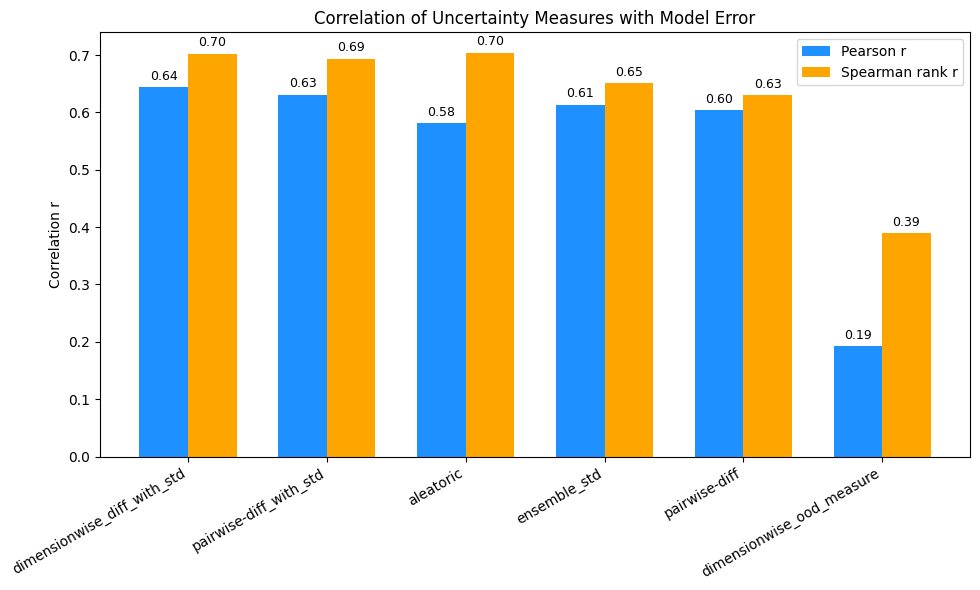

In [11]:
plotter.plot_correlation_bars(doc, uncertainty_measures, error_key='model_error_l2', title='Correlation of Uncertainty Measures with Model Error', print_corr_values=True, fig_size=(10, 6))

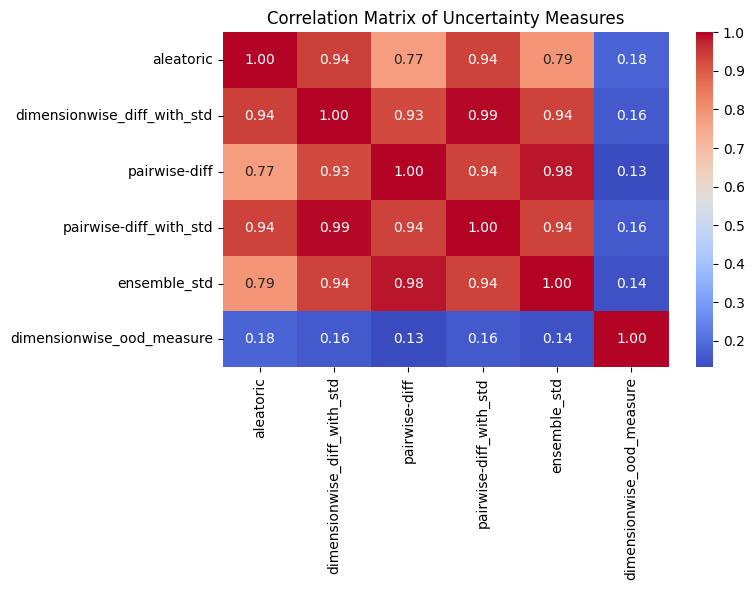

In [12]:
# Prepare data for correlation matrix
uncertainty_data = np.stack([doc[k] for k in uncertainty_measures], axis=1)
corr_matrix = np.corrcoef(uncertainty_data, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, xticklabels=uncertainty_measures, yticklabels=uncertainty_measures, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Uncertainty Measures")
plt.tight_layout()
plt.show()

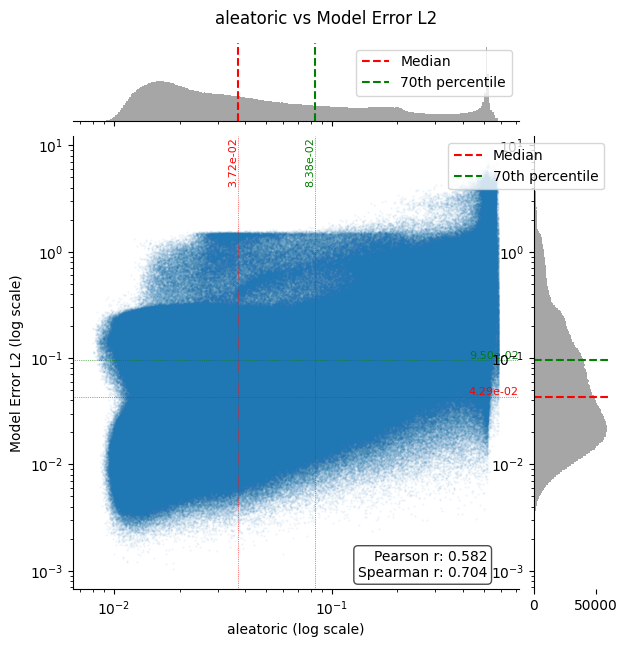

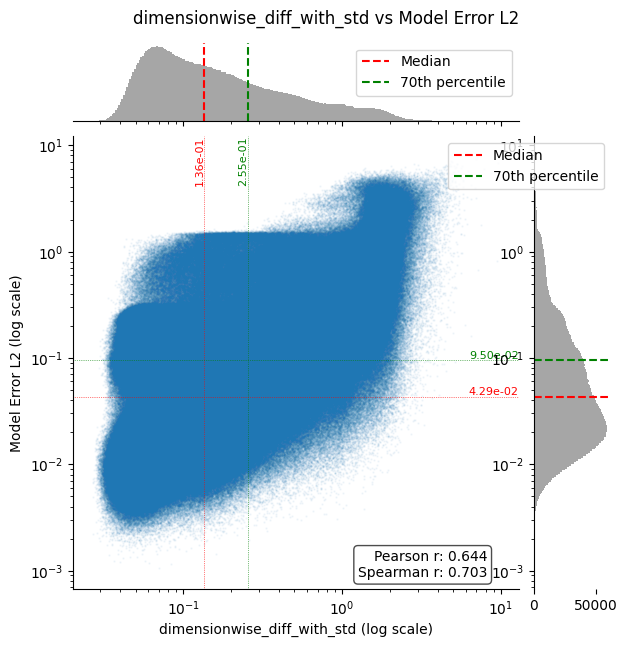

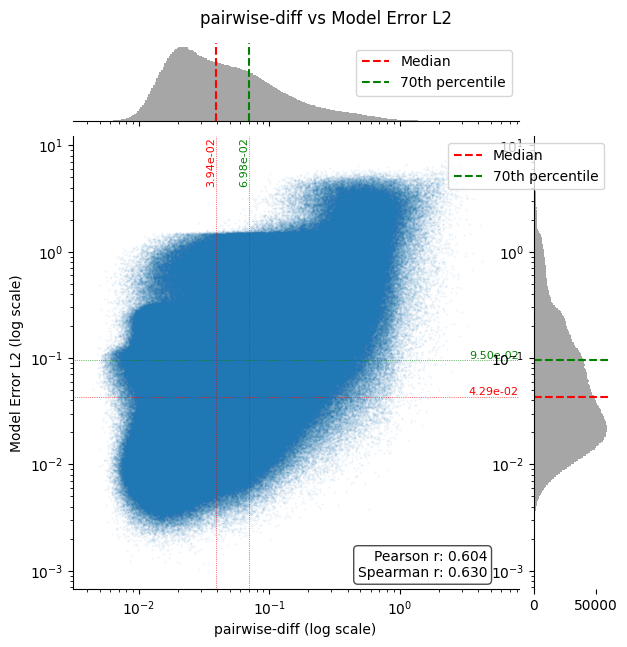

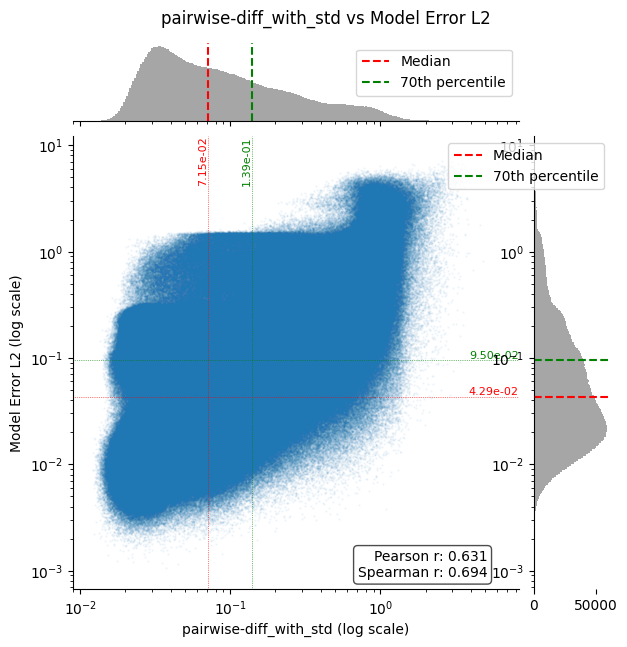

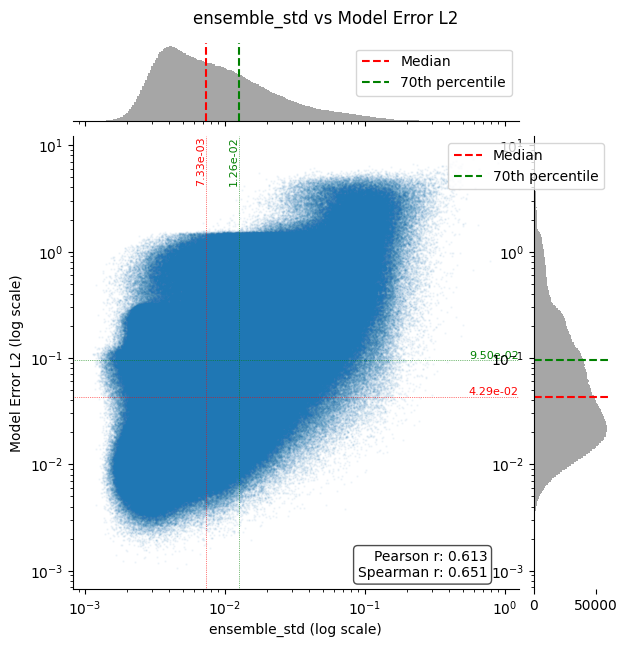

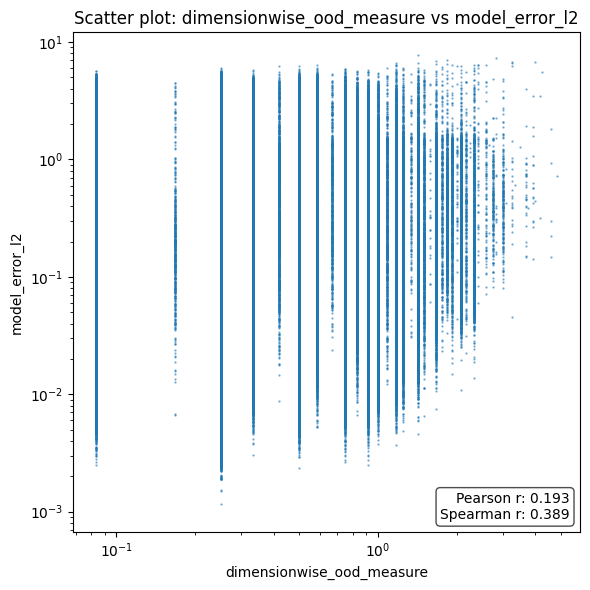

In [13]:
for u in uncertainty_measures:
    if u != "dimensionwise_ood_measure":
        plotter.plot_scatter_correlation(
            x=doc[u],
            y=doc["model_error_l2"],
            title=f"{u} vs Model Error L2",
            xlabel=u,
            ylabel="Model Error L2",
            bins=256,
            mark_percentile=70,
            fig_size=(6, 6),
            points_s=0.5,
            points_alpha=0.05
        )
    else:
        plotter.plot_simple_scatter_correlation(doc, u, "model_error_l2")


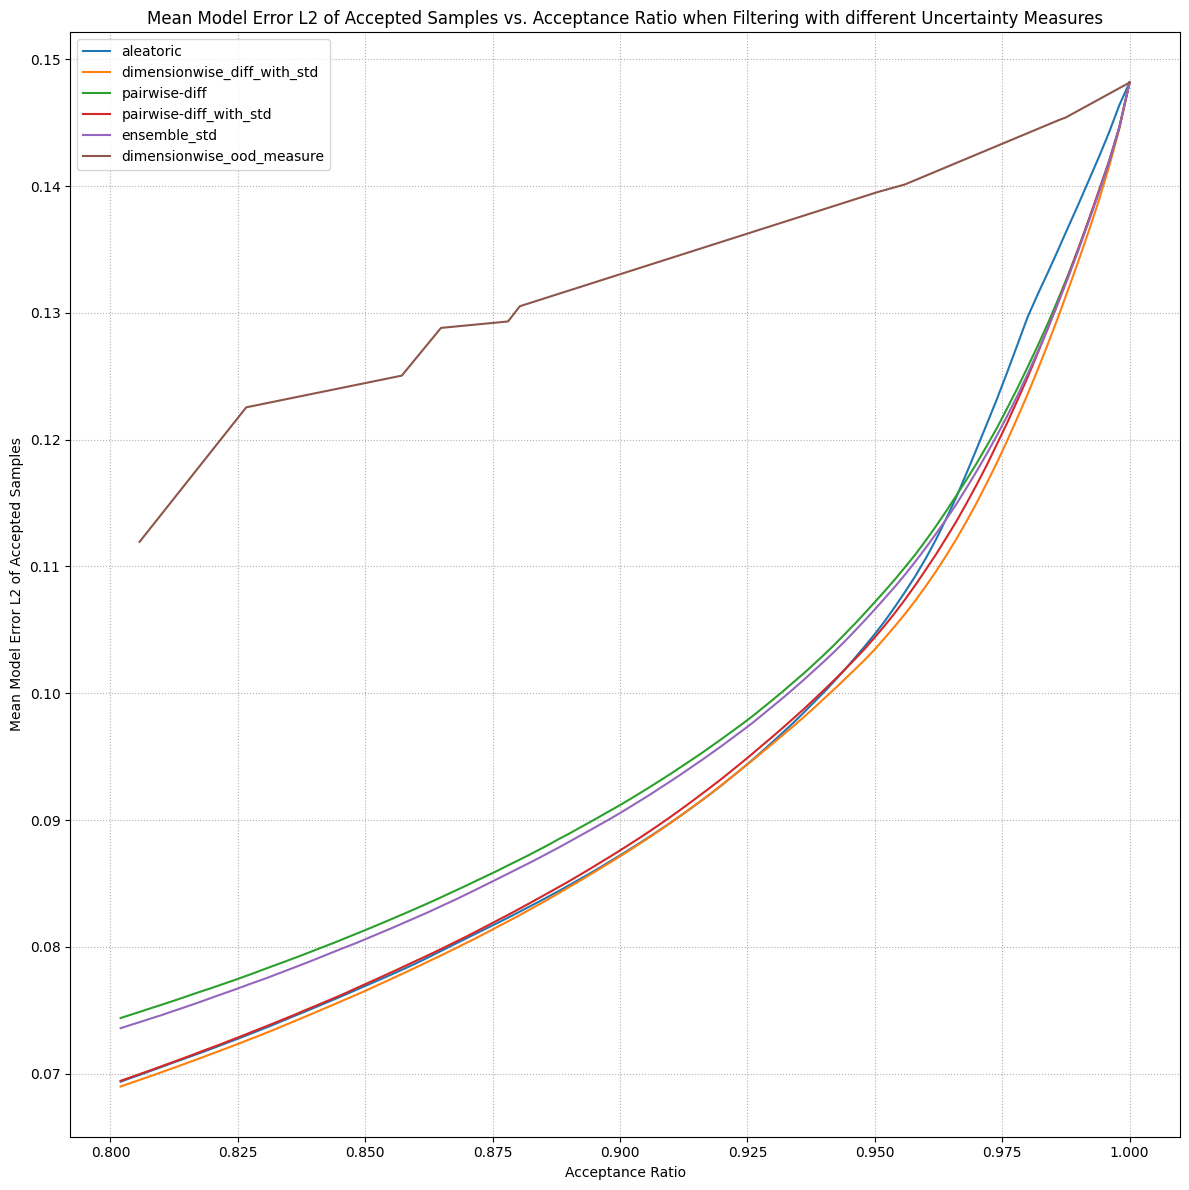

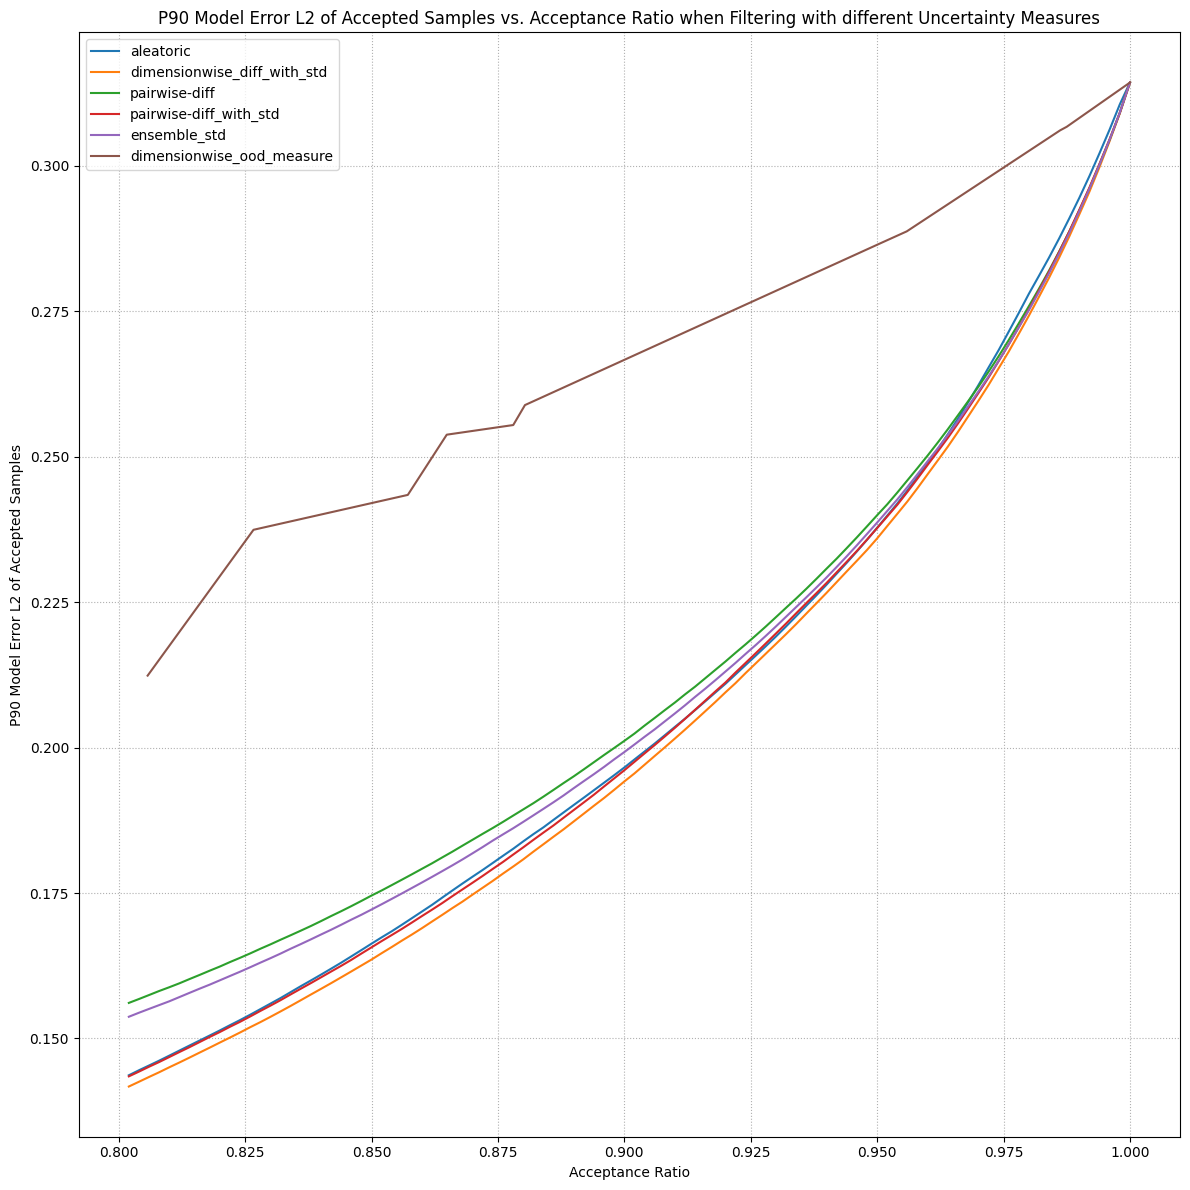

In [14]:
filter_thresholds_mean = plotter.plot_model_error_vs_acceptance_ratio(doc, uncertainty_measures, statistic="mean", plot_lower_bound=0.8, target_acceptance_ratio=target_acceptance_ratio)
filter_thresholds_p90 = plotter.plot_model_error_vs_acceptance_ratio(doc, uncertainty_measures, statistic="p90", plot_lower_bound=0.8, target_acceptance_ratio=target_acceptance_ratio)

In [15]:
criterion_mean = {
    "err": np.inf,
    "measure": None,
    "threshold": None,
    "acceptance": None
}
for k, v in filter_thresholds_mean.items():
    if v['mean_model_error'] < criterion_mean['err']:
        criterion_mean['err'] = v['mean_model_error']
        criterion_mean['measure'] = k
        criterion_mean['threshold'] = v['threshold']
        criterion_mean['acceptance'] = v['acceptance']

criterion_mean

{'err': 0.12358582415471717,
 'measure': 'dimensionwise_diff_with_std',
 'threshold': 1.7071082592010498,
 'acceptance': 0.9799996223766728}

In [16]:
criterion_p90 = {
    "err": np.inf,
    "measure": None,
    "threshold": None,
    "acceptance": None
}
for k, v in filter_thresholds_p90.items():
    if v['p90_model_error'] < criterion_p90['err']:
        criterion_p90['err'] = v['p90_model_error']
        criterion_p90['measure'] = k
        criterion_p90['threshold'] = v['threshold']
        criterion_p90['acceptance'] = v['acceptance']
criterion_p90

{'err': 0.27418805341915936,
 'measure': 'dimensionwise_diff_with_std',
 'threshold': 1.7071082592010498,
 'acceptance': 0.9799996223766728}

#### Fit OLS Model

In [17]:
unc_data = np.stack([doc[k] for k in ["dimensionwise_diff_with_std", "pairwise-diff_with_std", "dimensionwise_ood_measure"]]).T
target = doc["model_error_l2"]
unc_data.shape, target.shape

((4978506, 3), (4978506,))

In [18]:
# Fit linear regression model
reg_strength = 0.5
beta = np.linalg.inv(unc_data.T @ unc_data + reg_strength) @ unc_data.T @ target
y_hat = unc_data @ beta
beta, y_hat.shape

(array([ 1.07144124, -1.0063092 ,  0.06636405]), (4978506,))

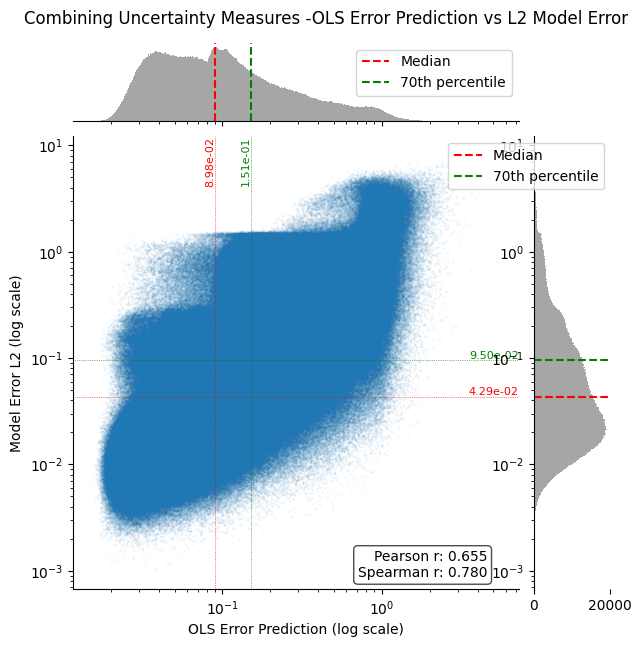

In [19]:
plotter.plot_scatter_correlation(x= y_hat, y=doc["model_error_l2"], title=f"Combining Uncertainty Measures -OLS Error Prediction vs L2 Model Error", xlabel="OLS Error Prediction", ylabel="Model Error L2", bins=800, mark_percentile=70, fig_size=(6, 6), points_s=0.5, points_alpha=0.05)

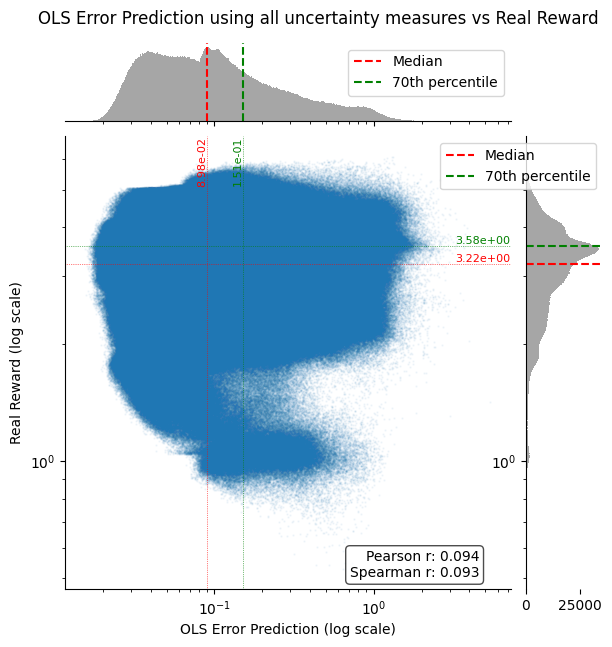

In [20]:
plotter.plot_scatter_correlation(x= y_hat, y=doc["rewards_real"], title=f"OLS Error Prediction using all uncertainty measures vs Real Reward", xlabel="OLS Error Prediction", ylabel="Real Reward", bins=800, mark_percentile=70, fig_size=(6, 6), points_s=0.5, points_alpha=0.05)

=> No correlation between discrepancy measures and real rewards. Thus, by filtering out data with high discrepancy measure we don't remove well performing transitions in particular

## Heuristic Filter Criterion

In [21]:
criterion_mean, criterion_p90,

({'err': 0.12358582415471717,
  'measure': 'dimensionwise_diff_with_std',
  'threshold': 1.7071082592010498,
  'acceptance': 0.9799996223766728},
 {'err': 0.27418805341915936,
  'measure': 'dimensionwise_diff_with_std',
  'threshold': 1.7071082592010498,
  'acceptance': 0.9799996223766728})

In [22]:
#criterion_mean["threshold"]=14.8
#criterion_p90["threshold"]=4.1

In [23]:
# Simple Thresholding Criterion based on best individual uncertainty measure for mean and P90

if criterion_mean['measure'] == criterion_p90['measure']:
    filter_indicator = (doc[criterion_mean['measure']] > criterion_mean['threshold'])
    filter_criterion_text = f"{criterion_mean['measure']} > {criterion_mean['threshold']:.2f}"
else:
    filter_indicator = (doc[criterion_mean['measure']] > criterion_mean['threshold']) | (doc[criterion_p90['measure']] > criterion_p90['threshold'])
    filter_criterion_text = f"({criterion_mean['measure']} > {criterion_mean['threshold']:.2f}) OR ({criterion_p90['measure']} > {criterion_p90['threshold']:.2f})"
filter_indicator.shape

(4978506,)

In [24]:
f"{100-(sum(filter_indicator) / len(filter_indicator))*100:.2f} % of data accepted"

'98.00 % of data accepted'

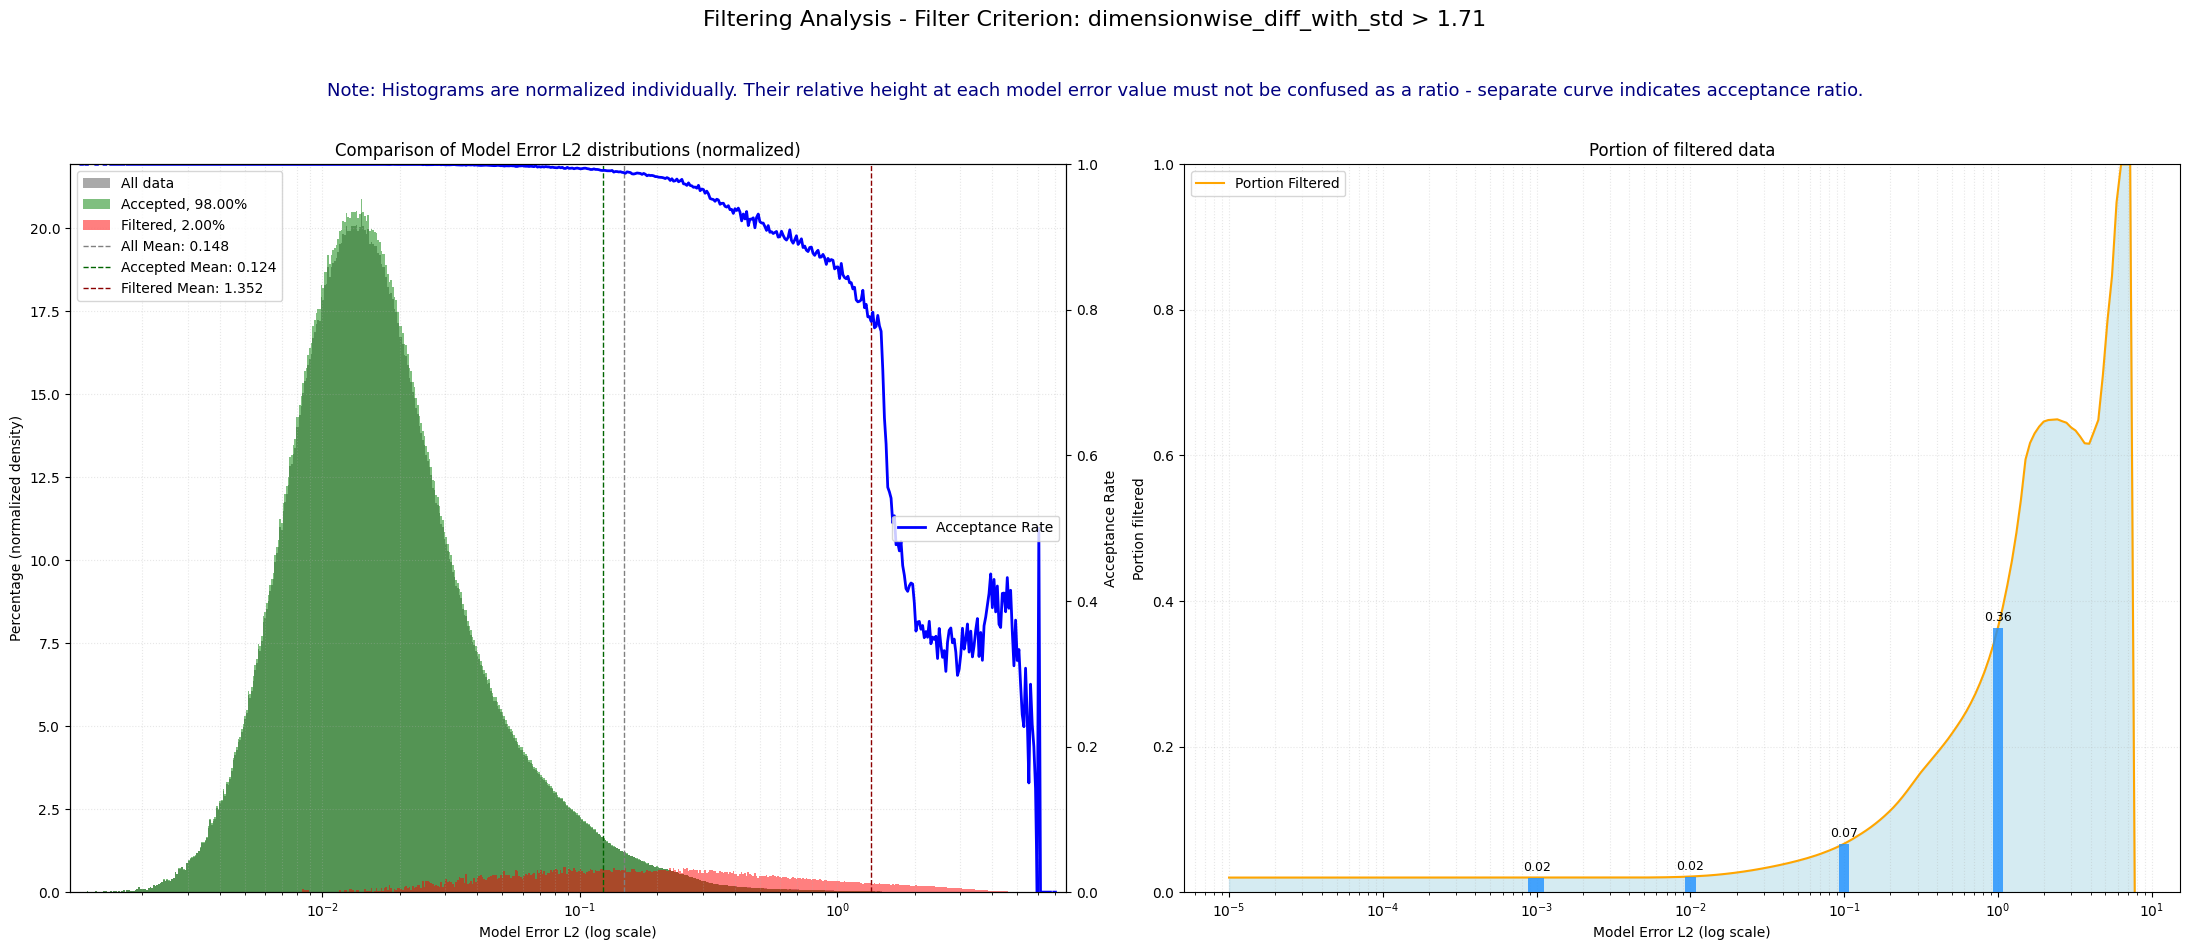

In [25]:
filter_stats = plotter.plot_filtering_analysis(doc, filter_indicator=filter_indicator, bins=600, fig_size=(22, 9), filter_criterion=filter_criterion_text)

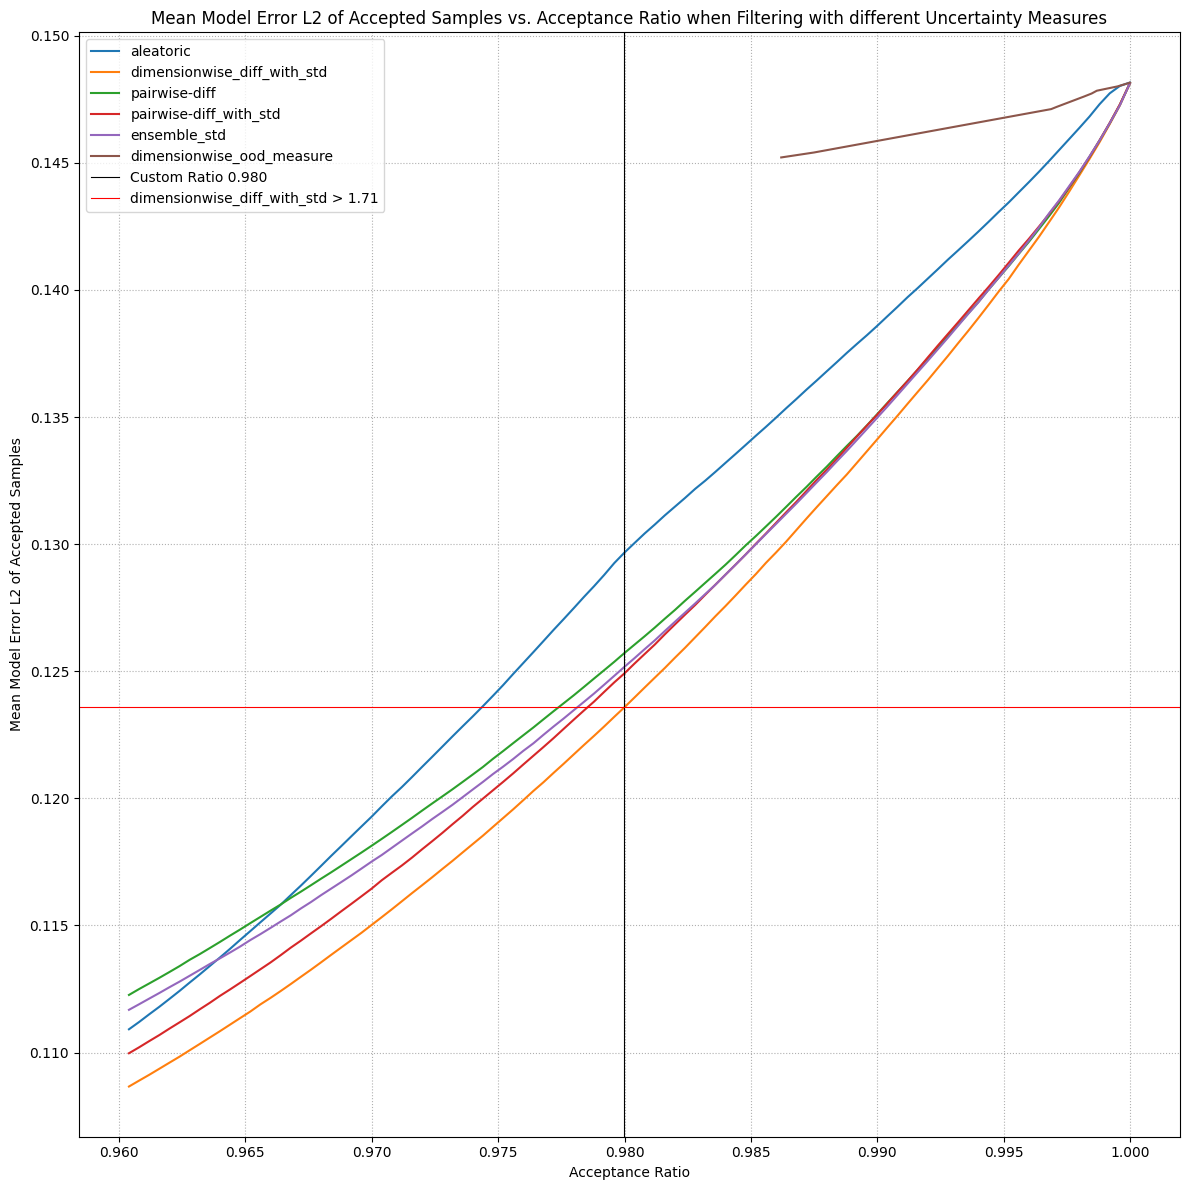

{}

In [26]:
custom_criterion = (filter_stats["Accepted"]["portion"], filter_stats["Accepted"]["mean"], filter_criterion_text)
plotter.plot_model_error_vs_acceptance_ratio(doc, uncertainty_measures, statistic="mean", plot_lower_bound=0.96, custom_criterion=custom_criterion)

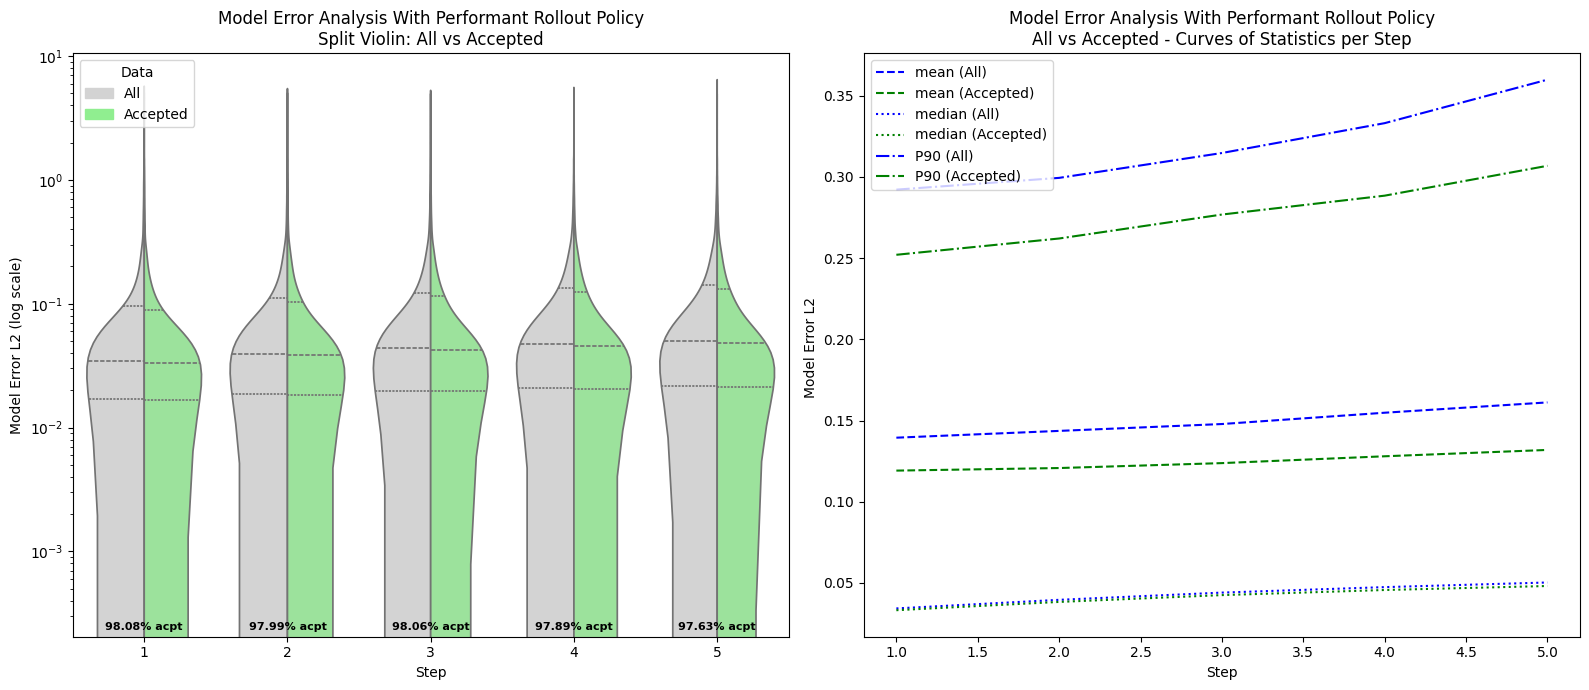

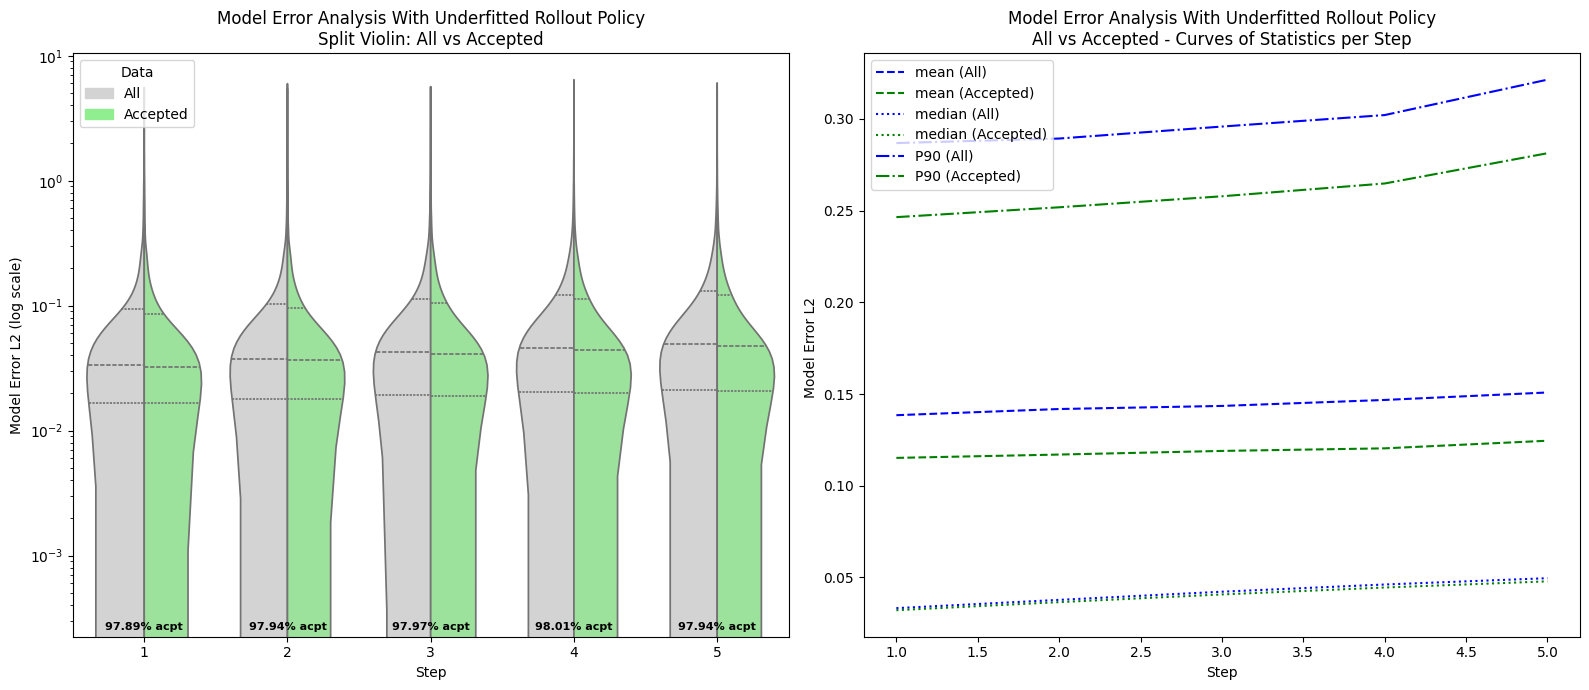

In [27]:
biggest_two = np.unique(doc["epoch"])[-2:].tolist()
smallest_two = np.unique(doc["epoch"])[:2].tolist()
plotter.plot_model_error_all_vs_accepted_per_step(doc, filter_indicator, epoch_vals=biggest_two, title='Model Error Analysis With Performant Rollout Policy', statistics=["mean", "median", "P90"], curves_logscale=False)
plotter.plot_model_error_all_vs_accepted_per_step(doc, filter_indicator, epoch_vals=smallest_two, title='Model Error Analysis With Underfitted Rollout Policy', statistics=["mean", "median", "P90"], curves_logscale=False)

=> Model error doesn't change much with rollout policy actor quality (with same dynamics model)